# Gene-to-graph workflow

This notebook showcases the steps to generate the BioDataFuse data and graph serializations from a list of genes.

Datasource or annotators used:
- Bgee
- DisGeNET
- OpenTargets
- MINERVA
- WikiPathways
- AOP-Wiki
- MolMedDB
- STRINGDB
- PubChem


In [1]:
# Import modules
import os
import pickle

import pandas as pd
from IPython.display import Image, display

import pyBiodatafuse.annotators as ann
import pyBiodatafuse.constants as Cons
from pyBiodatafuse import id_mapper
from pyBiodatafuse.graph.rdf import BDFGraph
from pyBiodatafuse.graph.rdf.graphdb import GraphDBManager
from pyBiodatafuse.graph.saver import save_graph
from pyBiodatafuse.utils import (
    combine_sources,
    create_harmonized_input_file,
    create_or_append_to_metadata,
)

/opt/anaconda3/envs/pybiodatafuse/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Entity resolution with BridgeDB

The first step is to input the list of genes to query and retrieve their protein target and synonym identifiers using BridgeDB.

### 1.1. Load the input list and convert it to a dataframe

In [2]:
genes_of_interest = """7350
6198
1499
6528
6714
10000
10891
6194
7068
4193
3709
"""

gene_list = genes_of_interest.split("\n")
data_input = pd.DataFrame(gene_list, columns=["identifier"])
data_input.head()

,identifier
0,7350
1,6198
2,1499
3,6528
4,6714


### 1.2. Query BridgeDB
The results will be stored in the following directories:

In [3]:
# Create directories
base_dir = os.path.abspath(os.getcwd())
DATA_DIR = os.path.join(base_dir, "data")
EXAMPLE_DIR = os.path.join(DATA_DIR, "gene_to_graph_workflow")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(EXAMPLE_DIR, exist_ok=True)

In [4]:
pickle_path = f"{EXAMPLE_DIR}/gene_list.pkl"
metadata_path = f"{EXAMPLE_DIR}/gene_list_metadata.pkl"

if not os.path.exists(pickle_path):
    bridgedb_df, bridgedb_metadata = id_mapper.bridgedb_xref(
        identifiers=data_input,
        input_species="Human",
        input_datasource="NCBI Gene",
        output_datasource="All",
    )
    bridgedb_df.to_pickle(pickle_path)
    with open(metadata_path, "wb") as file:
        pickle.dump(bridgedb_metadata, file)
else:
    bridgedb_df = pd.read_pickle(pickle_path)
    with open(metadata_path, "rb") as file:
        bridgedb_metadata = pickle.load(file)

In [5]:
print("Number of genes with mapping in BridgeDb:", len(bridgedb_df["identifier"].unique()))
bridgedb_df.head()

Number of genes with mapping in BridgeDb: 11


,identifier,identifier.source,target,target.source
0,7350,Entrez Gene,7350,NCBI Gene
1,7350,Entrez Gene,P25874,Uniprot-TrEMBL
2,7350,Entrez Gene,HGNC:12517,HGNC Accession Number
3,7350,Entrez Gene,ENSG00000109424,Ensembl
4,7350,Entrez Gene,UCP1,HGNC


## 2. Gene expression
### 2.1. Gene expression from Bgee

In [6]:
bgee_path = f"{EXAMPLE_DIR}/bgee.pkl"
bgee_metadata_path = f"{EXAMPLE_DIR}/bgee_metadata.pkl"

if not os.path.exists(bgee_path):
    bgee_df, bgee_metadata = ann.bgee.get_gene_expression(bridgedb_df=bridgedb_df)
    bgee_df.to_pickle(bgee_path)
    with open(bgee_metadata_path, "wb") as file:
        pickle.dump(bgee_metadata, file)
else:
    bgee_df = pd.read_pickle(bgee_path)
    with open(bgee_metadata_path, "rb") as file:
        bgee_metadata = pickle.load(file)

In [7]:
bgee_df.head(2)

,identifier,identifier.source,target,target.source,Bgee_gene_expression_levels
0,10000,Entrez Gene,ENSG00000117020,Ensembl,"[{'anatomical_entity_id': 'UBERON:0000178', 'a..."
1,10891,Entrez Gene,ENSG00000109819,Ensembl,"[{'anatomical_entity_id': 'UBERON:0000178', 'a..."


## 3. Disease annotation
### 3.1. Gene to disease annotation with DisGeNET

In [8]:
disgenet_path = f"{EXAMPLE_DIR}/disgenet.pkl"
disgenet_metadata_path = f"{EXAMPLE_DIR}/disgenet_metadata.pkl"

disgenet_api_key = "191dc560-6d91-43c0-ae9f-01655efdf6d5"

if not os.path.exists(disgenet_path):
    disgenet_df, disgenet_metadata = ann.disgenet.get_gene_disease(
        api_key=disgenet_api_key, bridgedb_df=bridgedb_df
    )

    disgenet_df.to_pickle(disgenet_path)
    with open(disgenet_metadata_path, "wb") as file:
        pickle.dump(disgenet_metadata, file)
else:
    disgenet_df = pd.read_pickle(disgenet_path)
    with open(disgenet_metadata_path, "rb") as file:
        disgenet_metadata = pickle.load(file)

In [9]:
disgenet_df.head(2)

,identifier,identifier.source,target,target.source,DISGENET_diseases
0,10000,Entrez Gene,10000,NCBI Gene,"[{'disease_name': 'melanoma', 'HPO': 'HPO:HP:0..."
1,10891,Entrez Gene,10891,NCBI Gene,"[{'disease_name': 'Diabetes Mellitus, Non-Insu..."


### 3.2. Disease to compound annotation from OpenTargets

In [10]:
# Prepare the input to use DISGENET output as seed for OpenTargets
disease_mapping_df = create_harmonized_input_file(
    annotated_df=disgenet_df, target_col=Cons.DISGENET_DISEASE_COL, target_source=Cons.EFO
)
disease_mapping_df.head()

,identifier,identifier.source,target,target.source
0,10000,Entrez Gene,EFO_0000756,EFO
1,10000,Entrez Gene,EFO_0000673,EFO
2,10000,Entrez Gene,EFO_0001663,EFO
3,10000,Entrez Gene,EFO_0000519,EFO
5,10000,Entrez Gene,EFO_0000349,EFO


In [11]:
opentarget_path = f"{EXAMPLE_DIR}/opentarget_cmpd.pkl"
opentarget_metadata_path = f"{EXAMPLE_DIR}/opentarget_cmpd_metadata.pkl"

if not os.path.exists(opentarget_path):
    opentargets_df, opentargets_metadata = ann.opentargets.get_disease_compound_interactions(
        disease_mapping_df
    )
    opentargets_df.to_pickle(opentarget_path)
    with open(opentarget_metadata_path, "wb") as file:
        pickle.dump(opentargets_metadata, file)
else:
    opentargets_df = pd.read_pickle(opentarget_path)
    with open(opentarget_metadata_path, "rb") as file:
        opentargets_metadata = pickle.load(file)

## 4. Pathways and Gene Ontology terms
### 4.1. Pathways from MINERVA

In [12]:
minerva_path = f"{EXAMPLE_DIR}/minerva.pkl"
minerva_metadata_path = f"{EXAMPLE_DIR}/minerva_metadata.pkl"

if not os.path.exists(minerva_path):
    minerva_df, minerva_metadata = ann.minerva.get_gene_pathways(
        bridgedb_df, map_name="COVID19 Disease Map"
    )
    minerva_df.to_pickle(minerva_path)
    with open(minerva_metadata_path, "wb") as file:
        pickle.dump(minerva_metadata, file)

else:
    minerva_df = pd.read_pickle(minerva_path)
    with open(minerva_metadata_path, "rb") as file:
        minerva_metadata = pickle.load(file)

In [13]:
minerva_df.head(2)

,identifier,identifier.source,target,target.source,MINERVA_pathways
0,10000,Entrez Gene,ENSG00000117020,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
1,10891,Entrez Gene,ENSG00000109819,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."


### 4.2. Pathways from WikiPathways

In [14]:
wikipathways_path = f"{EXAMPLE_DIR}/wikipathways.pkl"
wikipathways_metadata_path = f"{EXAMPLE_DIR}/wikipathways_metadata.pkl"

if not os.path.exists(wikipathways_path):
    wikipathways_df, wikipathways_metadata = ann.wikipathways.get_gene_wikipathways(
        bridgedb_df=bridgedb_df
    )
    wikipathways_df.to_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "wb") as file:
        pickle.dump(wikipathways_metadata, file)

else:
    wikipathways_df = pd.read_pickle(wikipathways_path)
    with open(wikipathways_metadata_path, "rb") as file:
        wikipathways_metadata = pickle.load(file)

In [15]:
# Compound-gene interactions
wikipathways_molecular_path = f"{EXAMPLE_DIR}/wikipathways_molecular.pkl"
wikipathways_molecular_metadata_path = f"{EXAMPLE_DIR}/wikipathways_molecular_metadata.pkl"

if not os.path.exists(wikipathways_molecular_path):
    wikipathways_molecular_df, wikipathways_molecular_metadata = (
        ann.wikipathways.get_gene_wikipathways(bridgedb_df=bridgedb_df, query_interactions=True)
    )
    wikipathways_molecular_df.to_pickle(wikipathways_molecular_path)
    with open(wikipathways_molecular_metadata_path, "wb") as file:
        pickle.dump(wikipathways_molecular_metadata, file)
else:
    wikipathways_molecular_df = pd.read_pickle(wikipathways_molecular_path)
    with open(wikipathways_molecular_metadata_path, "rb") as file:
        wikipathways_molecular_metadata = pickle.load(file)

In [16]:
wikipathways_molecular_df.head(2)

,identifier,identifier.source,target,target.source,WikiPathways_molecular
0,10000,Entrez Gene,10000,NCBI Gene,"[{'pathway_id': 'WP:3981', 'pathway_label': 'm..."
1,10891,Entrez Gene,10891,NCBI Gene,"[{'pathway_id': 'WP:5470', 'pathway_label': 'E..."


### 4.3. Reactome pathways from OpenTargets

In [17]:
opentargets_reactome_path = f"{EXAMPLE_DIR}/opentargets_reactome.pkl"
opentargets_reactome_metadata_path = f"{EXAMPLE_DIR}/opentargets_reactome_metadata.pkl"


if not os.path.exists(opentargets_reactome_path):
    opentargets_reactome_df, opentargets_reactome_metadata = (
        ann.opentargets.get_gene_reactome_pathways(bridgedb_df=bridgedb_df)
    )
    opentargets_reactome_df.to_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "wb") as file:
        pickle.dump(opentargets_reactome_metadata, file)
else:
    opentargets_reactome_df = pd.read_pickle(opentargets_reactome_path)
    with open(opentargets_reactome_metadata_path, "rb") as file:
        opentargets_reactome_metadata = pickle.load(file)

In [18]:
opentargets_reactome_df.head(2)

,identifier,identifier.source,target,target.source,OpenTargets_reactome
0,10000,Entrez Gene,ENSG00000117020,Ensembl,"[{'pathway_label': 'FLT3 Signaling', 'pathway_..."
1,10891,Entrez Gene,ENSG00000109819,Ensembl,[{'pathway_label': 'Transcriptional regulation...


### 4.4. Gene Ontology from OpenTargets

In [19]:
opentargets_go_path = f"{EXAMPLE_DIR}/opentargets_go.pkl"
opentargets_go_metadata_path = f"{EXAMPLE_DIR}/opentargets_go_metadata.pkl"

if not os.path.exists(opentargets_go_path):
    opentargets_go_df, opentargets_go_metadata = ann.opentargets.get_gene_go_process(
        bridgedb_df=bridgedb_df
    )
    opentargets_go_df.to_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "wb") as file:
        pickle.dump(opentargets_go_metadata, file)
else:
    opentargets_go_df = pd.read_pickle(opentargets_go_path)
    with open(opentargets_go_metadata_path, "rb") as file:
        opentargets_go_metadata = pickle.load(file)

### 4.5. Adverse Outcome Pathways from AOP-Wiki RDF

In [20]:
aopwiki_path = f"{EXAMPLE_DIR}/aopwiki.pkl"
aopwiki_metadata_path = f"{EXAMPLE_DIR}/aopwiki_metadata.pkl"

if not os.path.exists(aopwiki_path):
    aopwiki_df, aopwiki_metadata = ann.aopwiki.get_aops(
        bridgedb_df=bridgedb_df,
        input_type="gene",
        input_identifier="Ensembl",
    )
    aopwiki_df.to_pickle(aopwiki_path)
    with open(aopwiki_metadata_path, "wb") as file:
        pickle.dump(aopwiki_metadata, file)
else:
    aopwiki_df = pd.read_pickle(aopwiki_path)
    with open(aopwiki_metadata_path, "rb") as file:
        aopwiki_metadata = pickle.load(file)

In [21]:
aopwiki_df.head(2)

,identifier,identifier.source,target,target.source,AOP Wiki RDF_results
0,10000,Entrez Gene,ENSG00000117020,Ensembl,"[{'aop': nan, 'aop_title': nan, 'MIEtitle': na..."
1,10891,Entrez Gene,ENSG00000109819,Ensembl,"[{'aop': nan, 'aop_title': nan, 'MIEtitle': na..."


## 5. Compound annotation
### 5.1. Compound annotation from OpenTargets

In [22]:
opentargets_gene_path = f"{EXAMPLE_DIR}/opentargets_gene_cmpd.pkl"
opentargets_gene_metadata_path = f"{EXAMPLE_DIR}/opentargets_gene_cmpd_metadata.pkl"

if not os.path.exists(opentargets_gene_path):
    opentargets_compound_df, opentargets_compound_metadata = (
        ann.opentargets.get_gene_compound_interactions(bridgedb_df=bridgedb_df)
    )
    opentargets_compound_df.to_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "wb") as file:
        pickle.dump(opentargets_compound_metadata, file)

else:
    opentargets_compound_df = pd.read_pickle(opentargets_gene_path)
    with open(opentargets_gene_metadata_path, "rb") as file:
        opentargets_compound_metadata = pickle.load(file)

### 5.2. Screening results of compounds on proteins encoded by genes annotation by PubChem

In [23]:
pubchem_path = f"{EXAMPLE_DIR}/pubchem.pkl"
pubchem_metadata_path = f"{EXAMPLE_DIR}/pubchem_metadata.pkl"

if not os.path.exists(pubchem_path):
    pubchem_assay_df, pubchem_assay_metadata = ann.pubchem.get_protein_compound_screened(
        bridgedb_df=bridgedb_df
    )
    pubchem_assay_df.to_pickle(pubchem_path)
    with open(pubchem_metadata_path, "wb") as file:
        pickle.dump(pubchem_assay_metadata, file)

else:
    pubchem_assay_df = pd.read_pickle(pubchem_path)
    with open(pubchem_metadata_path, "rb") as file:
        pubchem_assay_metadata = pickle.load(file)

In [24]:
pubchem_assay_df.head(2)

,identifier,identifier.source,target,target.source,PubChem_assays
0,10000,Entrez Gene,A0A5F9ZGY0,Uniprot-TrEMBL,"[{'pubchem_assay_id': nan, 'assay_type': nan, ..."
1,10000,Entrez Gene,A0A5F9ZGZ4,Uniprot-TrEMBL,"[{'pubchem_assay_id': nan, 'assay_type': nan, ..."


### 5.3 Transporter inhibitor annotation from MolMeDB

In [25]:
molmedb_path = f"{EXAMPLE_DIR}/molmedb.pkl"
molmedb_metadata_path = f"{EXAMPLE_DIR}/molmedb_metadata.pkl"

if not os.path.exists(molmedb_path):
    inhibitor_df, inhibitor_metadata = ann.molmedb.get_gene_compound_inhibitor(
        bridgedb_df=bridgedb_df
    )
    inhibitor_df.to_pickle(molmedb_path)
    with open(molmedb_metadata_path, "wb") as file:
        pickle.dump(inhibitor_metadata, file)
else:
    inhibitor_df = pd.read_pickle(molmedb_path)
    with open(molmedb_metadata_path, "rb") as file:
        inhibitor_metadata = pickle.load(file)

> **NOTE**: No output for this database.

## 6. Protein-Protein Interactions

### 6.1. Protein-Protein Interactions from STRING

In [26]:
string_path = f"{EXAMPLE_DIR}/string.pkl"
string_metadata_path = f"{EXAMPLE_DIR}/string_metadata.pkl"

if not os.path.exists(string_path):
    ppi_df, ppi_metadata = ann.stringdb.get_ppi(bridgedb_df=bridgedb_df)
    ppi_df.to_pickle(string_path)
    with open(string_metadata_path, "wb") as file:
        pickle.dump(ppi_metadata, file)
else:
    ppi_df = pd.read_pickle(string_path)
    with open(string_metadata_path, "rb") as file:
        ppi_metadata = pickle.load(file)

> **NOTE:** - No interactions between the genes found

## 7. Graph generation 

### 7.1. Combine all data and metadata

In [27]:
combined_df_path = f"{EXAMPLE_DIR}/combined_df.pkl"
disease_compound_df_path = f"{EXAMPLE_DIR}/disease_compound_df.pkl"

if not os.path.exists(combined_df_path):
    combined_df = combine_sources(
        bridgedb_df,
        [
            bgee_df,
            disgenet_df,
            minerva_df,
            wikipathways_df,
            wikipathways_molecular_df,
            opentargets_reactome_df,
            opentargets_go_df,
            aopwiki_df,
            opentargets_compound_df,
            pubchem_assay_df,
            inhibitor_df,
            ppi_df,
        ],
    )
    combined_df.to_pickle(combined_df_path)
    opentargets_df.to_pickle(disease_compound_df_path)

else:
    combined_df = pd.read_pickle(combined_df_path)
    opentargets_df = pd.read_pickle(disease_compound_df_path)

In [28]:
combined_metadata = create_or_append_to_metadata(
    bridgedb_metadata,
    [
        bgee_metadata,
        disgenet_metadata,
        opentargets_metadata,
        opentargets_compound_metadata,
        inhibitor_metadata,
        pubchem_assay_metadata,
        ppi_metadata,
        wikipathways_metadata,
        minerva_metadata,
        opentargets_reactome_metadata,
        opentargets_go_metadata,
        aopwiki_metadata,
        wikipathways_molecular_metadata,
    ],
)

In [29]:
combined_df.head()

,identifier,identifier.source,target,target.source,Bgee_gene_expression_levels,DISGENET_diseases,MINERVA_pathways,WikiPathways_pathway,WikiPathways_molecular,OpenTargets_reactome,OpenTargets_go,AOP Wiki RDF_results,OpenTargets_gene_compounds,PubChem_assays
0,7350,Entrez Gene,ENSG00000109424,Ensembl,"[{'anatomical_entity_id': 'UBERON:0000955', 'a...","[{'disease_name': 'Obesity', 'HPO': 'HPO:HP:00...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': 'WP:WP3407', 'pathway_label': ...","[{'pathway_id': 'WP:4746', 'pathway_label': 'T...","[{'pathway_label': 'Mitochondrial Uncoupling',...","[{'go_id': 'GO:1990542', 'go_name': 'mitochond...","[{'aop': nan, 'aop_title': nan, 'MIEtitle': na...","[{'chembl_id': nan, 'drugbank_id': nan, 'compo...","[{'pubchem_assay_id': nan, 'assay_type': nan, ..."
1,6198,Entrez Gene,ENSG00000108443,Ensembl,"[{'anatomical_entity_id': 'UBERON:0000178', 'a...","[{'disease_name': 'Colorectal Carcinoma', 'HPO...","[{'pathway_id': 'MINERVA:939', 'pathway_label'...","[{'pathway_id': 'WP:WP5434', 'pathway_label': ...","[{'pathway_id': 'WP:4746', 'pathway_label': 'T...",[{'pathway_label': 'mTORC1-mediated signalling...,"[{'go_id': 'GO:0005739', 'go_name': 'mitochond...","[{'aop': nan, 'aop_title': nan, 'MIEtitle': na...","[{'chembl_id': 'CHEMBL:CHEMBL4650277', 'drugba...","[{'pubchem_assay_id': nan, 'assay_type': nan, ..."
2,6198,Entrez Gene,ENSG00000108443,Ensembl,"[{'anatomical_entity_id': 'UBERON:0000178', 'a...","[{'disease_name': 'Colorectal Carcinoma', 'HPO...","[{'pathway_id': 'MINERVA:939', 'pathway_label'...","[{'pathway_id': 'WP:WP5434', 'pathway_label': ...","[{'pathway_id': 'WP:4746', 'pathway_label': 'T...",[{'pathway_label': 'mTORC1-mediated signalling...,"[{'go_id': 'GO:0005739', 'go_name': 'mitochond...","[{'aop': nan, 'aop_title': nan, 'MIEtitle': na...","[{'chembl_id': 'CHEMBL:CHEMBL4650277', 'drugba...","[{'pubchem_assay_id': nan, 'assay_type': nan, ..."
3,6198,Entrez Gene,ENSG00000108443,Ensembl,"[{'anatomical_entity_id': 'UBERON:0000178', 'a...","[{'disease_name': 'Colorectal Carcinoma', 'HPO...","[{'pathway_id': 'MINERVA:939', 'pathway_label'...","[{'pathway_id': 'WP:WP5434', 'pathway_label': ...","[{'pathway_id': 'WP:4746', 'pathway_label': 'T...",[{'pathway_label': 'mTORC1-mediated signalling...,"[{'go_id': 'GO:0005739', 'go_name': 'mitochond...","[{'aop': nan, 'aop_title': nan, 'MIEtitle': na...","[{'chembl_id': 'CHEMBL:CHEMBL4650277', 'drugba...","[{'pubchem_assay_id': nan, 'assay_type': nan, ..."
4,6198,Entrez Gene,ENSG00000108443,Ensembl,"[{'anatomical_entity_id': 'UBERON:0000178', 'a...","[{'disease_name': 'Colorectal Carcinoma', 'HPO...","[{'pathway_id': 'MINERVA:939', 'pathway_label'...","[{'pathway_id': 'WP:WP5434', 'pathway_label': ...","[{'pathway_id': 'WP:4746', 'pathway_label': 'T...",[{'pathway_label': 'mTORC1-mediated signalling...,"[{'go_id': 'GO:0005739', 'go_name': 'mitochond...","[{'aop': nan, 'aop_title': nan, 'MIEtitle': na...","[{'chembl_id': 'CHEMBL:CHEMBL4650277', 'drugba...","[{'pubchem_assay_id': 'AID:1340854', 'assay_ty..."


### 7.2. Create a graph from the annotated dataframe

In [30]:
pygraph = save_graph(
    combined_df=combined_df,
    combined_metadata=combined_metadata,
    disease_compound=opentargets_df,
    graph_name="gene_to_graph",
    graph_dir=EXAMPLE_DIR,
)

Combined DataFrame saved in /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/data/gene_to_graph_workflow/gene_to_graph_df.pkl
Metadata saved in /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/data/gene_to_graph_workflow/gene_to_graph_metadata.pkl
Building graph: 100%|██████████| 78/78 [00:00<00:00, 102.83it/s]
Graph is built successfully
Graph saved in: 
 /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/data/gene_to_graph_workflow/gene_to_graph_graph.pkl 
 /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/data/gene_to_graph_workflow/gene_to_graph_graph.gml
Graph saved in /Users/yojana/Documents/GitHub/pyBiodatafuse/examples/data/gene_to_graph_workflow/gene_to_graph_graph.edgelist


In [31]:
# Check the node types in the graph

node_types = set()
for node, node_data in pygraph.nodes(data=True):
    node_types.add(node_data[Cons.LABEL])

print(node_types)

{'Cellular Component', 'Biological Process', 'Adverse Outcome', 'Anatomical Entity', 'Pathway', 'Compound', 'Disease', 'Gene', 'Molecular Function', 'Key Event', 'Adverse Outcome Pathway', 'Side Effect', 'Molecular Initiating Event'}


### 7.3. Neo4j

Make sure you have the desktop version open and have a user login and password. 

If you receive the error: `AuthError: {code: Neo.ClientError.Security.Unauthorized} {message: The client is unauthorized due to authentication failure.}`, please make sure you change disable authentication in the config file (dbms.security.auth_enabled=false). See [here](https://stackoverflow.com/questions/53687901/neo4j-cant-log-in-neo-clienterror-security-unauthorized-the-client-is-unauth)

In [32]:
from pyBiodatafuse.graph import neo4j

neo4j.load_graph(
    pygraph, uri="bolt://localhost:7687", username="test", password="password"
)  # change username and password

### 7.4. Cytoscape
Make sure that the Cytoscape is open.

In [33]:
import logging
import py4cytoscape as p4c
from pyBiodatafuse.graph import cytoscape

# Disable all logging for py4cytoscape
logging.disable(logging.CRITICAL)  # Disable all logging
cytoscape.load_graph(pygraph, network_name="Gene-Graph example")  # Load the graph into Cytoscape

Applying default style...
Applying preferred layout


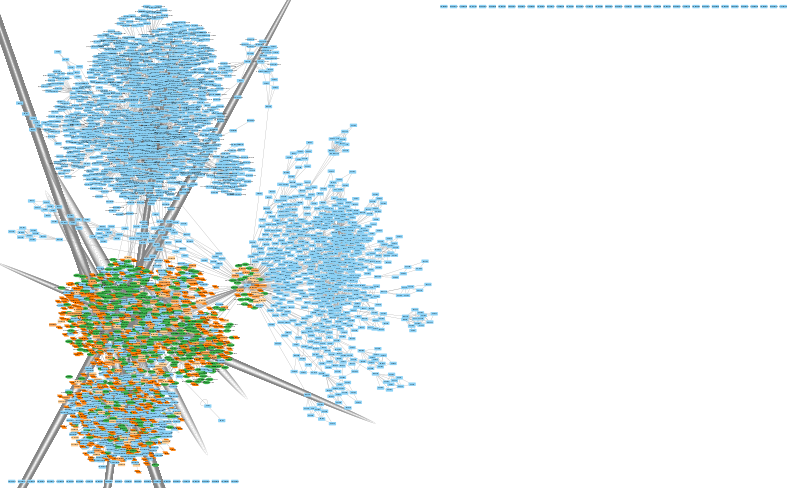

In [34]:
p4c.notebook_export_show_image()

### 7.5. RDF

In [35]:
# Instantiate a BDFGraph
bdf = BDFGraph(
    base_uri="https://biodatafuse.org/example/",
    version_iri="https://biodatafuse.org/example/test.owl",
    orcid="https://orcid.org/0000-0002-4166-7093",
    author="Javier Millan Acosta",
)

bdf.generate_rdf(combined_df, combined_metadata)  # Generate the RDF from the (meta)data

Building RDF graph: 100%|██████████| 78/78 [00:08<00:00,  8.71it/s]


In [36]:
bdf.serialize(
    os.path.join(
        base_dir,
        "data",
        "gene_to_graph_workflow",
        "BDF_example_graph.ttl",
    ),
    format="ttl",
)

<Graph identifier=Ne2afa469264e444c88fddd5e1b7e05f4 (<class 'pyBiodatafuse.graph.rdf.rdf.BDFGraph'>)>

##### 7.5.1. Generate prefixes SHACL

SHACL graphs defining namespaces and prefixes can be loaded into SPARQL endpoints to avoid having to declare prefixes in the query.

In [37]:
# Use without parameters (defaults, does not save file)
bdf.shacl_prefixes()
# or Use with parameters
bdf.shacl_prefixes(
    path=os.path.join(
        base_dir,
        "examples",
        "data",
        "gene_to_graph_workflow",
        "gene_to_graph_workflow",
        "BDF_prefixes.ttl",
    ),
    namespaces=None,  # Optional, add more namespaces with a dictionary of {prefix:namespace,}
)

@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] sh:declare [ sh:namespace "http://www.w3.org/1999/02/22-rdf-syntax-ns#"^^xsd:anyURI ;
            sh:prefix "rdf" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/datasource"^^xsd:anyURI ;
            sh:prefix "data_source_base_node" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/"^^xsd:anyURI ;
            sh:prefix "bdf" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/anatomical_entity"^^xsd:anyURI ;
            sh:prefix "anatomical_entity_base_node" ] .

[] sh:declare [ sh:namespace "https://monarchinitiative.org/disease/"^^xsd:anyURI ;
            sh:prefix "mondo" ] .

[] sh:declare [ sh:namespace "http://purl.obolibrary.org/obo/"^^xsd:anyURI ;
            sh:prefix "obo" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/gene"^^xsd:anyURI ;
            sh:prefix "gene_base_node" ] .

[] sh:declare [ sh:namespace "htt

<Graph identifier=N0b57cc9c955e4406929c37099a67a8fc (<class 'rdflib.graph.Graph'>)>

##### 7.5.2. Use [`shexer`](https://github.com/DaniFdezAlvarez/shexer/) to retrieve the RDF shapes

The `shexer` library is used to retrieve the shapes of the graph in SHACL (https://www.w3.org/TR/shacl/) and ShEx (https://shex.io/shex-semantics/).

- **SHACL**

@prefix : <http://weso.es/shapes/> .
@prefix bdfo: <https://biodatafuse.org/onto/bdf#> .
@prefix interaction: <https://biodatafuse.org/example/interaction> .
@prefix ns1: <http://vocabularies.wikipathways.org/wp#> .
@prefix obo: <http://purl.obolibrary.org/obo/> .
@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <https://schema.org/> .
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix sio: <http://semanticscience.org/resource/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

:DisGeNET_Evidence_Index a sh:NodeShape ;
    sh:property [ a sh:PropertyShape ;
            sh:in ( bdfo:DisGeNET_Evidence_Index ) ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:path rdf:type ],
        [ a sh:PropertyShape ;
            sh:dataType xsd:double ;
            sh:maxCount 1 ;
            sh:minCount 1 ;
            sh:path sio:SIO_000300

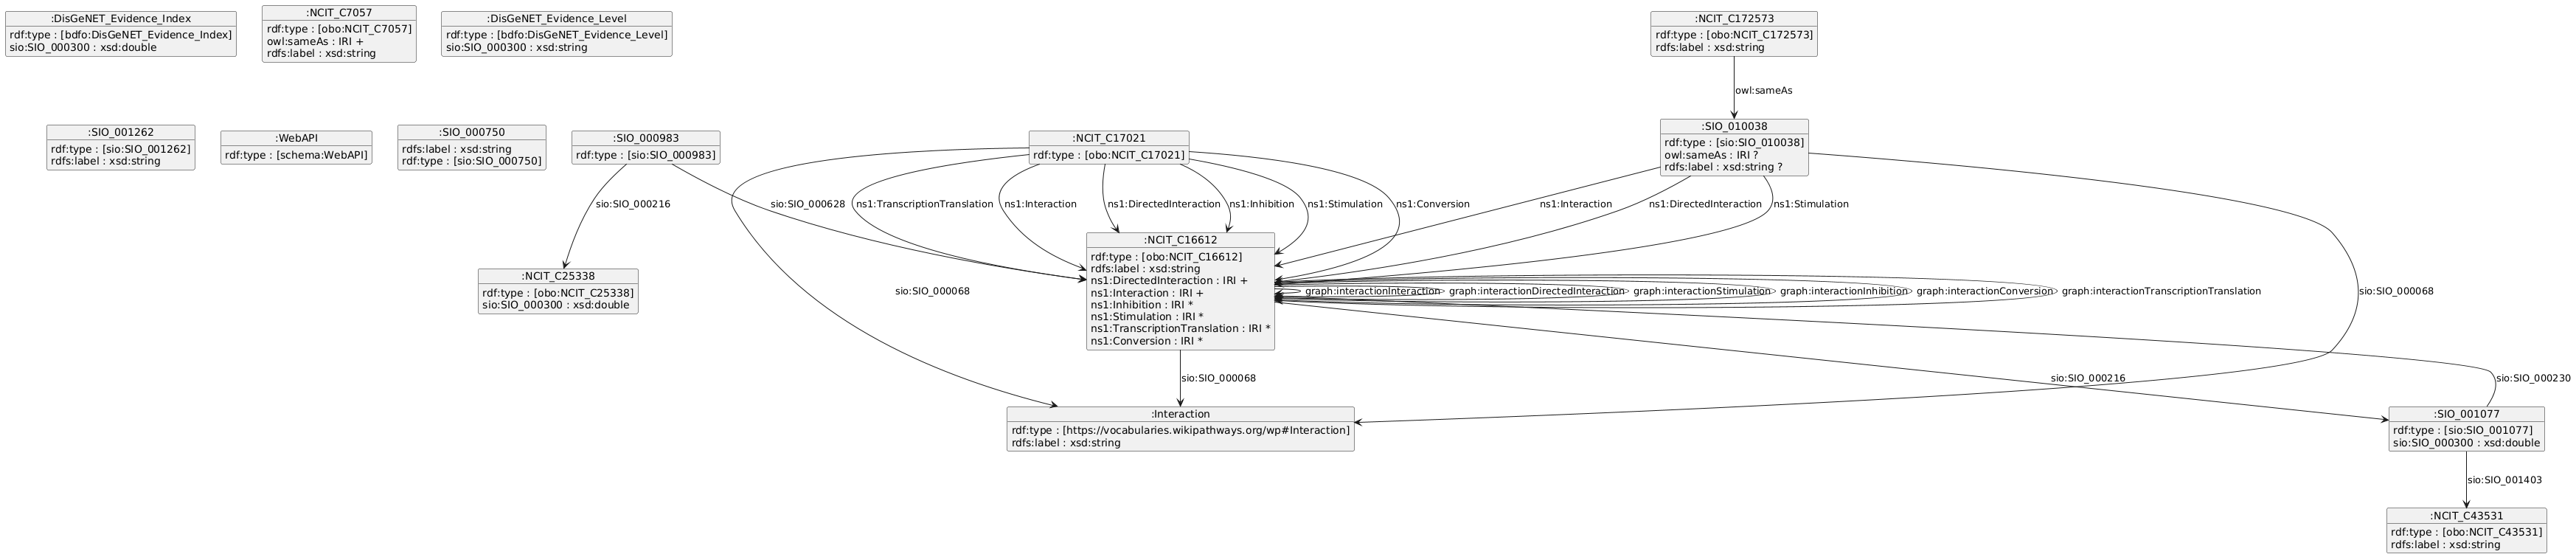

In [38]:
# Use without parameters (defaults)
# bdf.shacl()

# Or use with parameters
bdf.shacl(
    path=os.path.join(
        base_dir,
        "data",
        "gene_to_graph_workflow",
        "BDF_example_shacl.ttl",
    ),  # Set a path for TTL serialization
    threshold=0.001,
    uml_figure_path=os.path.join(
        base_dir,
        "data",
        "gene_to_graph_workflow",
        "BDF_example_shacl.png",
    ),  # Set a path for diagram
)

# Display the UML figure
display(
    Image(
        os.path.join(
            base_dir,
            "data",
            "gene_to_graph_workflow",
            "BDF_example_shacl.png",
        )
    )
)

- **ShEx**

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX ex: <http://example.org/>
PREFIX weso-s: <http://weso.es/shapes/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX obo: <http://purl.obolibrary.org/obo/>
PREFIX so: <http://purl.obolibrary.org/obo/so#>
PREFIX bdfo: <https://biodatafuse.org/onto/bdf#>
PREFIX minerva: <https://minerva-net.lcsb.uni.lu/api/>
PREFIX reactome: <https://reactome.org/content/detail/>
PREFIX uniprot: <https://www.uniprot.org/uniprotkb/>
PREFIX ensembl: <http://identifiers.org/ensembl#>
PREFIX graph: <https://biodatafuse.org/example/>
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX fo

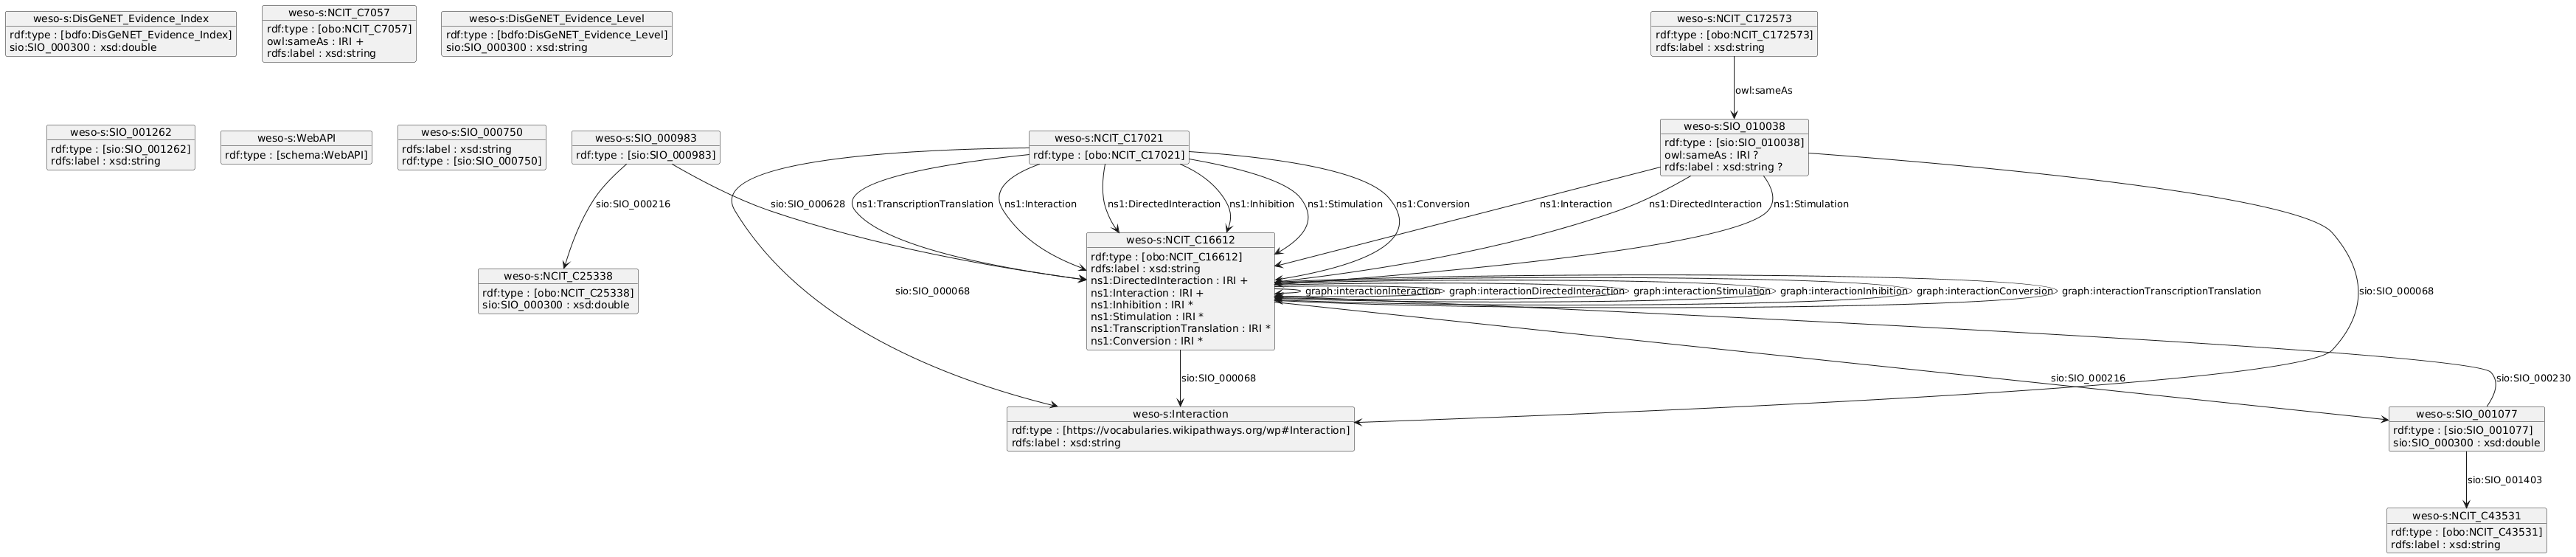

In [39]:
# Use without parameters (defaults)
# bdf.shex()

# Or use with parameters
bdf.shex(
    path=os.path.join(
        base_dir,
        "data",
        "gene_to_graph_workflow",
        "BDF_example_shex.ttl",
    ),  # Set a path for TTL serialization
    threshold=0.001,
    uml_figure_path=os.path.join(
        base_dir,
        "data",
        "gene_to_graph_workflow",
        "BDF_example_shex.png",
    ),  # Set a path for diagram
)

# Display the UML figure
display(
    Image(
        os.path.join(
            base_dir,
            "data",
            "gene_to_graph_workflow",
            "BDF_example_shex.png",
        )
    )
)

##### 7.5.3 Set up a GraphDB instance
- Download the latest version of GraphDB from https://graphdb.ontotext.com//
- Run from a direct access or terminal
- Open the GraphDB Workbench in your web browser by navigating to `http://localhost:7200`

The `GraphDBManager` allows you to perform simple operations on the your GraphDB location, such as creating a new repository, deleting a repository, importing RDF data into a repository, querying the loaded graphs and retrieving visualizations. For more advanced operations, you can use the GraphDB Workbench or the GraphDB API.

- Create a new repository

In [40]:
# GraphDB configuration
base_url = "http://localhost:7200"
repository_name = "gene_to_graph_workflow"
username = "admin"
password = "root"

print("Creating repository...")
GraphDBManager.create_repository(base_url, repository_name, username, password)

print("Listing repositories...")
repositories = GraphDBManager.list_repositories(base_url, username, password)
print("Repositories:", repositories)

Creating repository...
Listing repositories...
Repositories: [{'id': 'gene_to_graph_workflow', 'title': 'Gene_to_graph_workflow', 'uri': 'http://yojanas-MacBook-Pro:7200/repositories/gene_to_graph_workflow', 'externalUrl': 'http://yojanas-MacBook-Pro:7200/repositories/gene_to_graph_workflow', 'local': True, 'type': 'graphdb', 'sesameType': 'graphdb:SailRepository', 'location': '', 'readable': True, 'writable': True, 'unsupported': False, 'state': 'INACTIVE'}, {'id': 'biodatafuse', 'title': '', 'uri': 'http://yojanas-MacBook-Pro:7200/repositories/biodatafuse', 'externalUrl': 'http://yojanas-MacBook-Pro:7200/repositories/biodatafuse', 'local': True, 'type': 'graphdb', 'sesameType': 'graphdb:SailRepository', 'location': '', 'readable': True, 'writable': True, 'unsupported': False, 'state': 'RUNNING'}]


- Load the RDF data into the repository

In [41]:
print("Uploading RDF graph to GraphDB...")
GraphDBManager.upload_to_graphdb(
    base_url, repository_name, username, password, bdf, file_format="turtle"
)
print("Counting triples in the repository...")
triple_count = GraphDBManager.count_triples(base_url, repository_name, username, password)
print(f"Triple count: {str(triple_count)}")

Uploading RDF graph to GraphDB...
Counting triples in the repository...
Triple count: {'inferred': 120, 'total': 46293, 'explicit': 46173}


- Load the prefixes SHACL graph into the repository

In [42]:
print("Uploading Prefixes SHACL graph to GraphDB...")
GraphDBManager.upload_to_graphdb(
    base_url,
    repository_name,
    username,
    password,
    bdf.shacl_prefixes(),
)
print("Counting triples in the repository...")
triple_count = GraphDBManager.count_triples(base_url, repository_name, username, password)
print(f"Triple count: {str(triple_count)}")

Uploading Prefixes SHACL graph to GraphDB...
@prefix sh: <http://www.w3.org/ns/shacl#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/anatomical_entity"^^xsd:anyURI ;
            sh:prefix "anatomical_entity_base_node" ] .

[] sh:declare [ sh:namespace "http://www.w3.org/2000/01/rdf-schema#"^^xsd:anyURI ;
            sh:prefix "rdfs" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/score"^^xsd:anyURI ;
            sh:prefix "score_base_node" ] .

[] sh:declare [ sh:namespace "https://biodatafuse.org/example/gene"^^xsd:anyURI ;
            sh:prefix "gene_base_node" ] .

[] sh:declare [ sh:namespace "https://www.ncbi.nlm.nih.gov/medgen/"^^xsd:anyURI ;
            sh:prefix "umls" ] .

[] sh:declare [ sh:namespace "http://purl.obolibrary.org/obo/so#"^^xsd:anyURI ;
            sh:prefix "so" ] .

[] sh:declare [ sh:namespace "http://semanticscience.org/resource/"^^xsd:anyURI ;
            sh:prefix "sio

- Delete the repository

In [43]:
print("Deleting repository...")
repositories = GraphDBManager.list_repositories(base_url, username, password)
print("Repositories:", repositories)
GraphDBManager.delete_repository(base_url, repository_name, username, password)
print("Listing repositories...")
repositories = GraphDBManager.list_repositories(base_url, username, password)
print("Repositories:", repositories)

Deleting repository...
Repositories: [{'id': 'gene_to_graph_workflow', 'title': 'Gene_to_graph_workflow', 'uri': 'http://yojanas-MacBook-Pro:7200/repositories/gene_to_graph_workflow', 'externalUrl': 'http://yojanas-MacBook-Pro:7200/repositories/gene_to_graph_workflow', 'local': True, 'type': 'graphdb', 'sesameType': 'graphdb:SailRepository', 'location': '', 'readable': True, 'writable': True, 'unsupported': False, 'state': 'RUNNING'}, {'id': 'biodatafuse', 'title': '', 'uri': 'http://yojanas-MacBook-Pro:7200/repositories/biodatafuse', 'externalUrl': 'http://yojanas-MacBook-Pro:7200/repositories/biodatafuse', 'local': True, 'type': 'graphdb', 'sesameType': 'graphdb:SailRepository', 'location': '', 'readable': True, 'writable': True, 'unsupported': False, 'state': 'RUNNING'}]
Listing repositories...
Repositories: [{'id': 'biodatafuse', 'title': '', 'uri': 'http://yojanas-MacBook-Pro:7200/repositories/biodatafuse', 'externalUrl': 'http://yojanas-MacBook-Pro:7200/repositories/biodatafuse',